# Visualizing Earthquakes

This notebook was created to visualize some of the data provided by ANSS. The data can be used to explain some of the background information regarding seismic activity.

In this notebook we will explore:

1. **Foreshocks and Aftershocks** - Energy released post earthquake as a new equilibrium point is reached. 
2. **Swarms and Storms** - Similar to Foreshocks and Aftershocks. However they are a series of earthquakes that occur in the same area within a short period of time. 
3. **Earthquake Energy** - The relationships between the energy a single earthquake and the afromentioned events

### Back end Program Requirements - Data

The following code is used to ensure the proper data is imported so that graphs and visuals are properly displayed. 

---

In [77]:
#Check if Required CSV data exists in Working Directory
#if not present data is downloaded from github repo
#Download CSV data from Github
#This allows the notebook to be used outside of the git repo. For.. reasons yet unknown.
from pathlib2 import Path

combined = Path("m_combined.csv")
if combined.is_file():
    print("m_combined.csv - Exists")
else:
    print("m_combined.csv: DNE -- Downloading from Git")
    url = 'https://raw.githubusercontent.com/nevelo/quake-predict/master/csvData/m_combined.csv'
    fd = wget.download(url)

magCIdat = Path("mag_locationsCI.csv")
if magCIdat.is_file():
    print("mag_locationsCI.csv - Exists")
else:
    print("mag_locationsCI.csv: DNE -- Downloading from Git")
    url = 'https://raw.githubusercontent.com/nevelo/quake-predict/master/csvData/mag_locationsCI.csv'
    fd = wget.download(url)
    
magNCdat = Path("mag_locationsNC.csv")
if magNCdat.is_file():
    print("mag_locationsNC.csv - Exists")
else:
    print("mag_locationsNC.csv: DNE -- Downloading from Git")
    url = 'https://raw.githubusercontent.com/nevelo/quake-predict/master/csvData/mag_locationsNC.csv'
    fd = wget.download(url)

m_combined.csv - Exists
mag_locationsCI.csv - Exists
mag_locationsNC.csv - Exists


In [93]:
#Open Files
f_combined = open("m_combined.csv")
f_CI = open("mag_locationsCI.csv")
f_NC = open("mag_locationsNC.csv")

## Area of Interest

This data will be focusing on the San Andreas fault line in the Western United States. 

The two datasets we will focus are; 

* Northern California earthquake data center (NC) 
* Southern California Seismographs (CI).

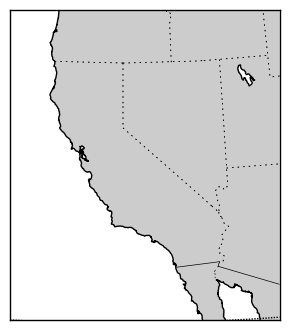

Here is the general region where our data is being pulled from


In [233]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.animation as animation

mp = Basemap(projection='tmerc',
    width = 120000, height = 900000000,
    lat_0=37.141240, lon_0=-120.046963,
    resolution = 'i', area_thresh = 1000.0,
    llcrnrlon=-126, llcrnrlat=30,
    urcrnrlon=-110, urcrnrlat=44)
 
mp.drawcoastlines()
mp.drawcountries()
mp.fillcontinents()
mp.drawmapboundary()
mp.drawstates(linestyle = 'dotted')

#mp.drawmeridians(np.arange(0, 360, 30))
mp.drawparallels(np.arange(-90, 90, 30))
 
my_map = plt.show()

print("Here is the general region where our data is being pulled from")

In [81]:
#Loading required variables from files
import csv

latsCI, lonsCI, magsCI = [],[],[]
latsNC, lonsNC, magsNC = [],[],[]

def getLatLngMag(to_parse):
    
    lats, lons, mags = [],[],[]
    
    with to_parse as f:
        reader = csv.reader(f)
        
        for row in reader:
            lats.append(float(row[3]))
            lons.append(float(row[4]))
            mags.append(float(row[5]))

    return (lats, lons, mags)

latsCI, lonsCI, magsCI = getLatLngMag(f_CI)
latsNC, lonsNC, magsNC = getLatLngMag(f_NC)

In [82]:
print("Lets check the data")

print("CI Data - first 5 - Size: " + str(len(latsCI)))
print("Lats: ", latsCI[0:10])
print("Lons: ", lonsCI[0:10])
print("Mags: ", magsCI[0:10])
print(" ")
print("NC Data - first 5 - Size: " + str(len(latsNC)))
print("Lats: ", latsNC[0:10])
print("Lons: ", lonsNC[0:10])
print("Mags: ", magsNC[0:10])

Lets check the data
CI Data - first 5 - Size: 468693
('Lats: ', [34.546, 34.543, 34.545, 33.809, 35.29, 34.383, 33.774, 33.735, 35.534, 34.413])
('Lons: ', [-118.934, -118.923, -118.937, -115.932, -117.485, -116.474, -115.991, -116.022, -118.433, -120.093])
('Mags: ', [2.95, 2.77, 1.73, 1.4, 1.4, 1.5, 1.74, 2.03, 1.1, 2.18])
 
NC Data - first 5 - Size: 588914
('Lats: ', [38.821, 37.66433, 37.63267, 37.6615, 37.66233, 37.63217, 38.819, 36.93133, 36.99033, 38.82784])
('Lons: ', [-122.80617, -118.84634, -119.04, -118.83417, -118.84016, -119.04083, -122.796, -121.51483, -121.732, -122.79317])
('Mags: ', [1.11, 0.98, 1.13, 0.83, 1.59, 2.04, 0.89, 1.16, 1.51, 0.96])


Lets plot the overall magnitudes

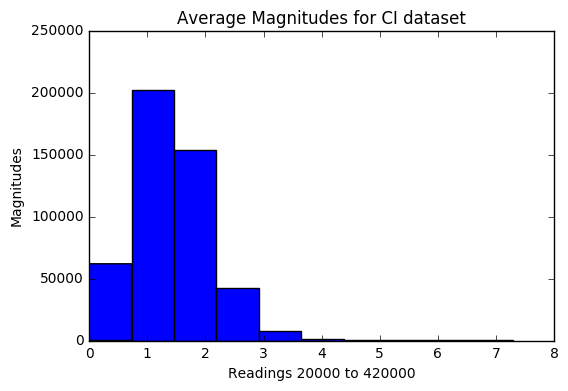

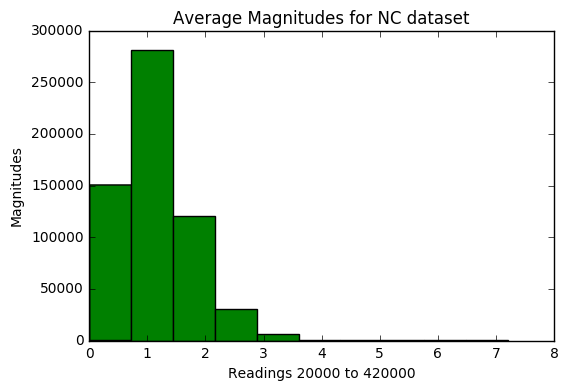

In [83]:
import matplotlib.pyplot as plt

#plot histograms of CI
plt.hist(magsCI, color='blue')

plt.xlabel('Readings ' + str(start) + ' to ' + str(end))
plt.ylabel('Magnitudes')
plt.title('Average Magnitudes for CI dataset')

plt.savefig('figs/hist_CI_magnitudes.png')
plt.show()

#plot histograms of NC
plt.hist(magsNC, color='green')

plt.xlabel('Readings ' + str(start) + ' to ' + str(end))
plt.ylabel('Magnitudes')
plt.title('Average Magnitudes for NC dataset')

plt.savefig('figs/hist_NC_magnitudes.png')
plt.show()

## Foreshocks and Aftershocks

For these plots, we found some good examples of earthquakes to use and plotted a smaller range.

The earthquake data we used in this case is from the April 4th 2010 - Baja California Quake.

---
Cells - Beginning of April 1st, End of April 6th
* CI cells (339140, 340658)
* NC Cells (397124, 397343)

In [84]:
CI_start, CI_end = 338000, 340658
NC_start, NC_end = 397004, 397343

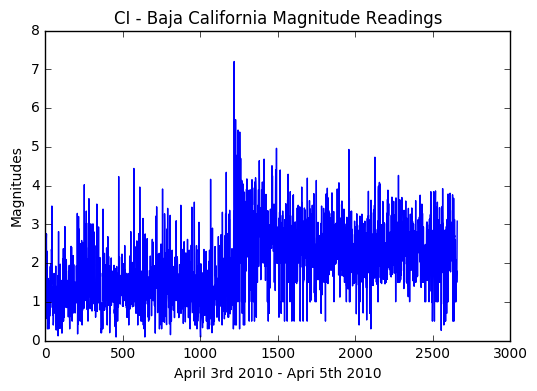

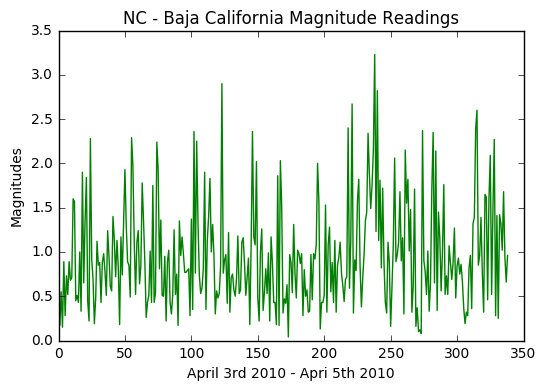

In [85]:
plt.plot(magsCI[CI_start:CI_end], color='blue')

plt.xlabel('April 3rd 2010 - Apri 5th 2010')
plt.ylabel('Magnitudes')
plt.title('CI - Baja California Magnitude Readings')

plt.savefig('figs/April-10-2010-MagnitudesCI.png')
plt.show()

plt.plot(magsNC[NC_start:NC_end], color='green')

plt.xlabel('April 3rd 2010 - Apri 5th 2010')
plt.ylabel('Magnitudes')
plt.title('NC - Baja California Magnitude Readings')

plt.savefig('figs/April-10-2010-MagnitudesNC.png')
plt.show()

We encountered our first issue when reading and interpreting at this point.

The issue is in the way that the data is being recorded. The more activity that exists in one area creates more readings. Because the earthquake struck below the border, the activity listed in the CI dataset is much higher than that of the NC readings. 

This not only makes it difficult to use the data in our LSTM architecture, but also hard to visualize. To be able to use this, we combined the two datasets and reorganized some of the data using the Panda Data Frame library. 

---

In [95]:
#Pulling data from m_combined.csv
    
sumMags, meanMags, sumPwr, meanPwr, dayReadings = [],[],[],[],[]
    
with f_combined as f:
    reader = csv.reader(f)
    
    firstLine = True
    for row in reader:
        if firstLine:
            firstLine = False
            continue
        
        sumMags.append(float(row[3]))
        meanMags.append(float(row[4]))
        sumPwr.append(float(row[5]))
        meanPwr.append(float(row[6]))
        dayReadings.append(float(row[9]))

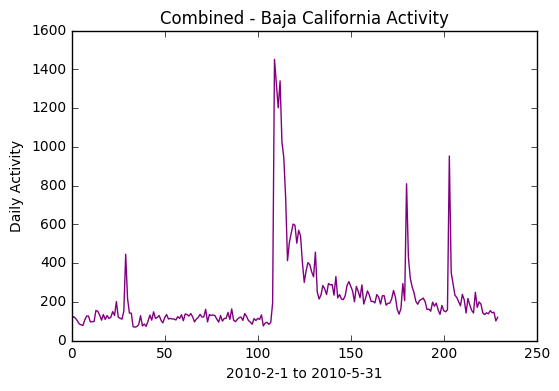

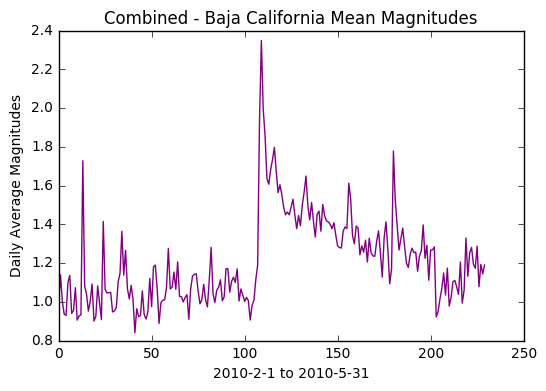

In [108]:
#now we can plot the given days and the general activity giving us a more accurate representation of the aftershocks

plt.plot(dayReadings[7290:7520], color='purple')

plt.xlabel('2010-2-1 to 2010-5-31')
plt.ylabel('Daily Activity')
plt.title('Combined - Baja California Activity')

plt.savefig('figs/April-10-2010-AverageReadings.png')
plt.show()


plt.plot(meanMags[7290:7520], color='purple')

plt.xlabel('2010-2-1 to 2010-5-31')
plt.ylabel('Daily Average Magnitudes')
plt.title('Combined - Baja California Mean Magnitudes')

plt.savefig('figs/April-10-2010-AverageMagnitudes.png')
plt.show()

Presto! Now we have a working data set! In addition, you can easily visualize foreshocks and aftershocks that occurred surrounding the earthquake. 

The mean magnitudes that are presented are low due to the ammount of readings that occurred. As the seismic activity increases the average mean will be squished. 

## Swarms and Storms

For these plots, we found some good examples of earthquakes to use and plotted a smaller range.
In this case we will filter out the activity after the Baja earthquake and plot how the earthquakes have a swarm like behaviour.

{30: ([<matplotlib.lines.Line2D at 0x7f7c214ee2d0>], [])}

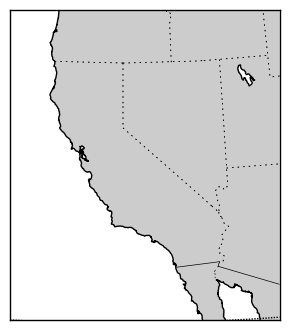

In [245]:
#re-drawing map

fig = plt.figure()
ax = plt.subplot(1,1,1)
mp = Basemap(projection='tmerc',
    width = 120000, height = 900000000,
    lat_0=37.141240, lon_0=-120.046963,
    resolution = 'i', area_thresh = 1000.0,
    llcrnrlon=-126, llcrnrlat=30,
    urcrnrlon=-110, urcrnrlat=44)
 
mp.drawcoastlines()
mp.drawcountries()
mp.fillcontinents()
mp.drawmapboundary()
mp.drawstates(linestyle = 'dotted')

#mp.drawmeridians(np.arange(0, 360, 30))
mp.drawparallels(np.arange(-90, 90, 30))

In [246]:
positions, newMag = [],[]

for x in range (NC_start,NC_end):
    if magsNC[x] > 0.2:
        positions.append((latsNC[x],lonsNC[x]))
        newMag.append(magsNC[x])  

E = np.zeros(len(newMag), dtype=[('position',  float, 2), ('magnitude', float, 1)])
E['position'] = positions
E['magnitude'] = newMag
        
print(E)

[([37.61967, -119.03567], 0.33) ([38.80933, -122.80766], 0.55)
 ([38.84167, -122.7865], 0.89) ([38.79117, -122.7385], 0.28)
 ([37.61733, -119.0235], 0.73) ([38.82084, -122.83], 0.52)
 ([38.79333, -122.76334], 0.89) ([37.56983, -118.83434], 0.68)
 ([37.55933, -119.0185], 0.71) ([37.43683, -121.789], 1.6)
 ([37.92867, -122.299], 1.57) ([38.79984, -122.7385], 0.45)
 ([38.80217, -122.81567], 0.51) ([38.84117, -122.80983], 0.43)
 ([37.42633, -121.76933], 1.0) ([38.81683, -122.83417], 0.33)
 ([35.72733, -121.06367], 1.9) ([38.7785, -122.71633], 0.65)
 ([38.85317, -122.94733], 1.35) ([38.76266, -122.45483], 1.84)
 ([38.80283, -122.82933], 0.44) ([38.766, -122.705], 0.22)
 ([39.35133, -123.18083], 2.28) ([38.8, -122.73967], 0.92)
 ([38.826, -122.8295], 0.69) ([38.79067, -122.74633], 0.48)
 ([35.88533, -120.43083], 1.12) ([37.4605, -118.91866], 0.85)
 ([38.79183, -122.80967], 0.88) ([38.8455, -122.82383], 0.43)
 ([38.82483, -122.80383], 0.88) ([38.75467, -122.71967], 0.98)
 ([38.79767, -122.757

In [254]:
P = np.zeros(50, dtype=[('position', float, 2),
                         ('size',     float, 1),
                         ('growth',   float, 1),
                         ('color',    float, 4)])
scat = ax.scatter(P['position'][:,0], P['position'][:,1], P['size'], lw=0.5,
                  edgecolors = P['color'], facecolors='None', zorder=10)

def update(frame):
    current = frame % len(E)
    i = frame % len(P)

    P['color'][:,3] = np.maximum(0, P['color'][:,3] - 1.0/len(P))
    P['size'] += P['growth']

    magnitude = E['magnitude'][current]
    P['position'][i] = mp(*E['position'][current])
    P['size'][i] = 5
    P['growth'][i]= np.exp(magnitude) * 0.1

    if magnitude < 2.2:
        P['color'][i]    = 0,0,1,1
    else:
        P['color'][i]    = 1,0,0,1
    scat.set_edgecolors(P['color'])
    scat.set_facecolors(P['color']*(1,1,1,0.25))
    scat.set_sizes(P['size'])
    scat.set_offsets(P['position'])
    return scat


anim = animation.FuncAnimation(fig, update, interval=5, frames=100)
plt.show()

In [255]:
anim.to_html5_video()

KeyError: u'ffmpeg'